## Dual Comb Model Testing

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
params = [{'rep_rate': 1.1e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': 0.01, 'jitter': 0.0, 'drift': 0.00, 'n_0': 0, 'alpha_0': 0.0},
          {'rep_rate': 1.0e0, 'pulse_duration': 60e-3, 'time': 1e3, 'sample_rate': 100e0, 'noise': 0.01, 'jitter': 0.05, 'drift': 0.1, 'n_0': 0.0, 'alpha_0': 0.0}]

comb1 = {}
comb2 = {}

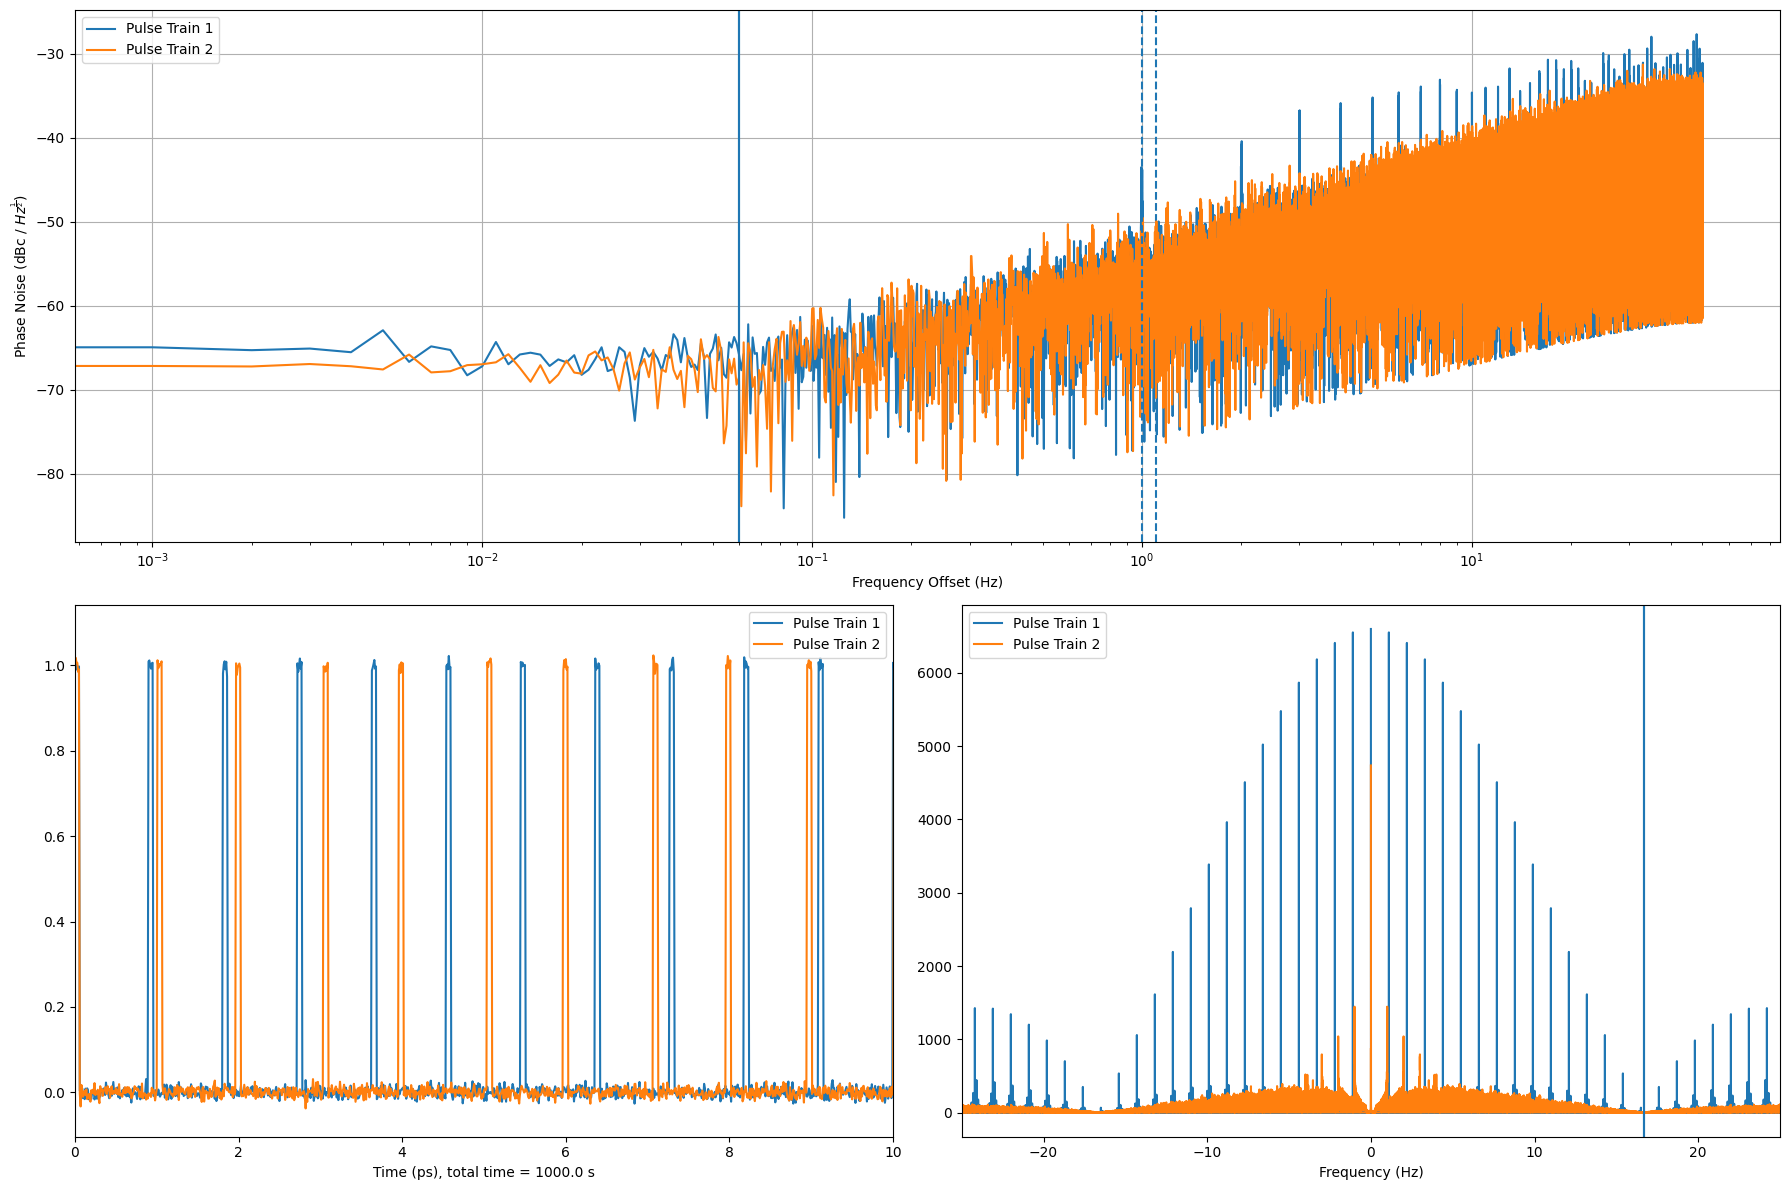

In [4]:
fig = plt.figure(figsize=(18,12),tight_layout=True)
axs = fig.subplot_mosaic([['T', 'T'],['BL', 'BR']],gridspec_kw={'width_ratios':[1, 1]})


for i, param in enumerate(params):
    num_samples = int(param['time'] * param['sample_rate'])
    t = np.linspace(0, param['time'], num_samples, endpoint=False)
    pulse_train = np.zeros_like(t)
    num_pulses = int(param['time'] * param['rep_rate'])
    pulse_samples = int(param['pulse_duration'] * param['sample_rate'])
    pulse_drift = np.linspace(0, param['drift']/param['rep_rate'], num_pulses)*np.exp(np.linspace(0, 100*param['drift'], num_pulses))
    pulse_times_noise = np.random.normal(loc=np.arange(num_pulses) / param['rep_rate'], scale=param['jitter'] / param['rep_rate'], size=num_pulses)
    pulse_times = np.add(pulse_times_noise, pulse_drift)
    
    # GENERATE COMB: PULSE TRAIN & SPECTRUM ####################################
    for pulse_time in pulse_times:
        start_index = int(pulse_time * param['sample_rate'])
        if start_index + pulse_samples < num_samples:
            pulse_train[start_index:start_index + pulse_samples] = 1

    pulse_train += param['noise'] * np.random.normal(size=num_samples)

    frequencies = np.fft.fftfreq(n=num_samples, d=1/param['sample_rate'])
    spectrum = np.fft.fft(pulse_train)

    # TRANSFER FUNCTION ########################################################
    L = 100e-3  # Path length in meters
    c = 3e8   # Speed of light in vacuum, meters per second
    n_0 = param['n_0'] #refractive index
    alpha_0 = param['alpha_0'] #apbsorption coefficient
    n = n_0 + 0.1 * np.sin(frequencies*2*np.pi) 
    alpha = alpha_0 * np.exp(-frequencies / 1.5e14) 
    H_absorption = np.exp(-alpha * L)
    H_phase = np.exp(-1j * 2 * np.pi * frequencies * (n - 1) * L / c)
    H = H_absorption * H_phase

    mod_spectrum = spectrum * H
    
    # PHASE NOISE #############################################################
    phase_angles = np.angle(spectrum)
    phase_diff = np.diff(phase_angles)  # Difference between phases
    # phase_diff = np.diff(spectrum)
    # spec_diff = np.diff(spectrum)
    # phase_diff = np.angle(spec_diff)
    power_spec_dens = np.abs(np.fft.ifft(phase_diff))**1 # Power spectral density
    pnd = 10 * np.log10(power_spec_dens / param['sample_rate'])  # Convert to dBc/Hz

    if i == 0:
        comb1['frequencies'] = frequencies
        comb1['pnp'] = power_spec_dens
        comb1['mod_spectrum'] = mod_spectrum
        comb1['pulse_train'] = pulse_train
    elif i == 1:
        comb2['frequencies'] = frequencies
        comb2['pnp'] = power_spec_dens
        comb2['mod_spectrum'] = mod_spectrum
        comb2['pulse_train'] = pulse_train

    # PLOT #####################################################################
    axs['T'].semilogx(frequencies[:num_samples//2], pnd[:num_samples//2], label=f'Pulse Train {i+1}')
    # axs['T'].semilogx(frequencies[:num_samples-1], pnd[:num_samples])
    # axs['T'].semilogx(frequencies[:num_samples-1], pnp[:num_samples])
    # axs['T'].semilogx(frequencies[:num_samples//2]/1e6, 10*np.log10(1/(frequencies[:num_samples//2]*1e-3)), 'r--')
    axs['T'].axvline(param['rep_rate'], linestyle='--')#, label=f'Rep Rate {i+1}')
    axs['T'].axvline(param['pulse_duration'])
    axs['T'].set_xlabel('Frequency Offset (Hz)')
    axs['T'].set_ylabel(r'Phase Noise (dBc / $Hz^{\frac{1}{2}}$)')
    # axs['T'].set_xlim(1e-0, 1e6)
    # axs['T'].set_ylim(-200, -0)
    axs['T'].grid(True)
    axs['T'].legend()

    axs['BL'].plot(t, pulse_train, label=f'Pulse Train {i+1}')
    axs['BL'].set_ylim(np.max(pulse_train) * np.array([-0.1, 1.1]))
    axs['BL'].set_xlabel(f'Time (ps), total time = {param['time']} s')
    axs['BL'].set_xlim(0, len(t)/10000)
    axs['BL'].legend()

    axs['BR'].plot(frequencies, np.abs(mod_spectrum), label=f'Pulse Train {i+1}')
    axs['BR'].axvline(16.666)
    axs['BR'].axvline(33.333)
    axs['BR'].set_xlabel('Frequency (Hz)')
    axs['BR'].set_xlim(-25, 25)
    axs['BR'].legend()

plt.tight_layout()
plt.show()

# Heterodyning

/var/folders/tl/2hjtn9nn2cv6j4rb1nygnp9c0000gn/T/ipykernel_49396/475629161.py:13: RuntimeWarning: invalid value encountered in sqrt
  phase_noise_dbc_hz = 10 * np.log10(np.array(phase_noise_power)/np.sqrt(np.array(frequencies[1:])) )


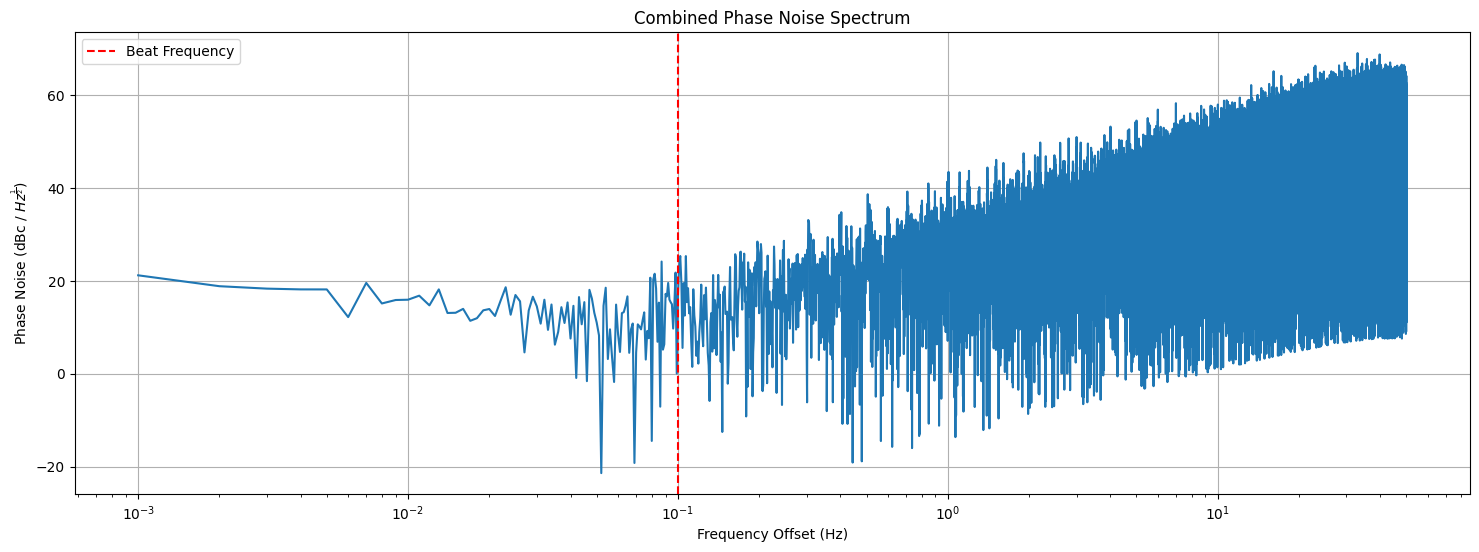

In [5]:
num = int(params[0]['time'] * params[0]['sample_rate'])
pulse_trains = [comb1['pulse_train'], comb2['pulse_train']]
combined_pulse_train = np.sum([pulse_trains[1]+ pulse_trains[0]], axis=0)
# combined_pulse_train = np.subtract(pulse_trains[1], pulse_trains[0])

fft_result = np.fft.fft(combined_pulse_train)
frequencies = np.fft.fftfreq(num, 1/params[0]['sample_rate'])

phase_angles = np.angle(fft_result)
phase_diff = np.diff(phase_angles) 
# phase_diff = np.diff(fft_result) 
phase_noise_power = np.abs(np.fft.fft(phase_diff))**2
phase_noise_dbc_hz = 10 * np.log10(np.array(phase_noise_power)/np.sqrt(np.array(frequencies[1:])) )

beat = np.abs(params[0]['rep_rate'] - params[1]['rep_rate'])

plt.figure(figsize=(18, 6))
plt.semilogx(frequencies[1:], phase_noise_dbc_hz)
# plt.semilogx(frequencies[:num//2-1], (phase_noise_power/params[0]['sample_rate'])[:num//2-1])
plt.axvline(beat, color='r', linestyle='--', label='Beat Frequency')
plt.title('Combined Phase Noise Spectrum')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Frequency Offset (Hz)')
plt.ylabel(r'Phase Noise (dBc / $Hz^{\frac{1}{2}}$)')
plt.grid(True)
plt.legend()
plt.show()